In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import re, sys, time
import seaborn as sns
from tqdm import tqdm_notebook
sys.path = ['..', '../../../rllab'] + sys.path
from baselines.pois.testing import create_sampler
from baselines import logger

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logs_names = glob('../tmp_logs/*.txt')

def parse_params(lines):
    points = []
    for i, line in enumerate(lines):
        if '| Bound' in line:
            param_line = lines[i-4]
            reward_line = lines[i+6]
            params = list(map(float, param_line[1:-2].split()))
            reward = float(reward_line.split('|')[2])
            points.append(params + [reward])
    return points
  
logs, logs_length = [], []
for i, file in enumerate(logs_names):
    with open(file) as f:
        lines = f.readlines()
        p = parse_params(lines)
        logs.extend(p)
        logs_length.append(len(p))
logs = np.array(logs)

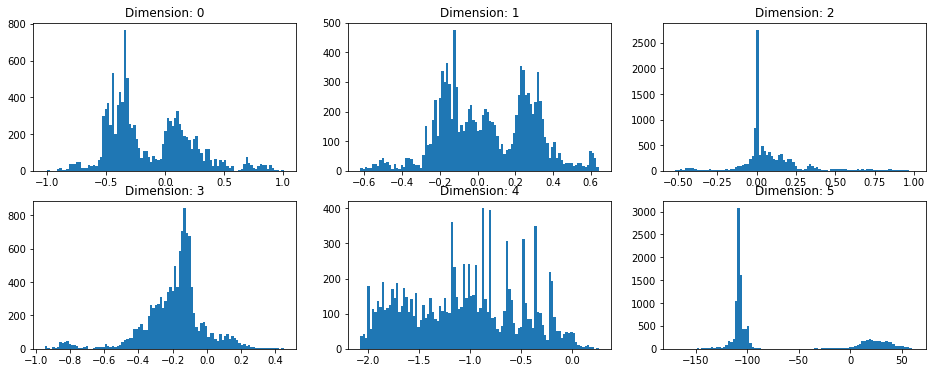

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))
for i in range(6):
    ax[i//3, i%3].hist(logs[:, i], bins=100)
    ax[i//3, i%3].set_title('Dimension: %s'%(i,))
plt.show();

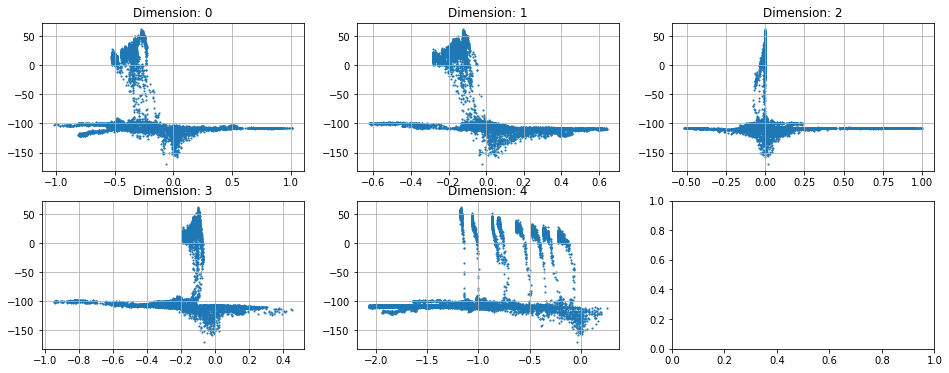

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))
for i in range(5):
    ax[i//3, i%3].scatter(logs[:,i], logs[:,5], s=1.2)
    ax[i//3, i%3].set_title('Dimension: %s'%(i,))
    ax[i//3, i%3].grid()
plt.show();

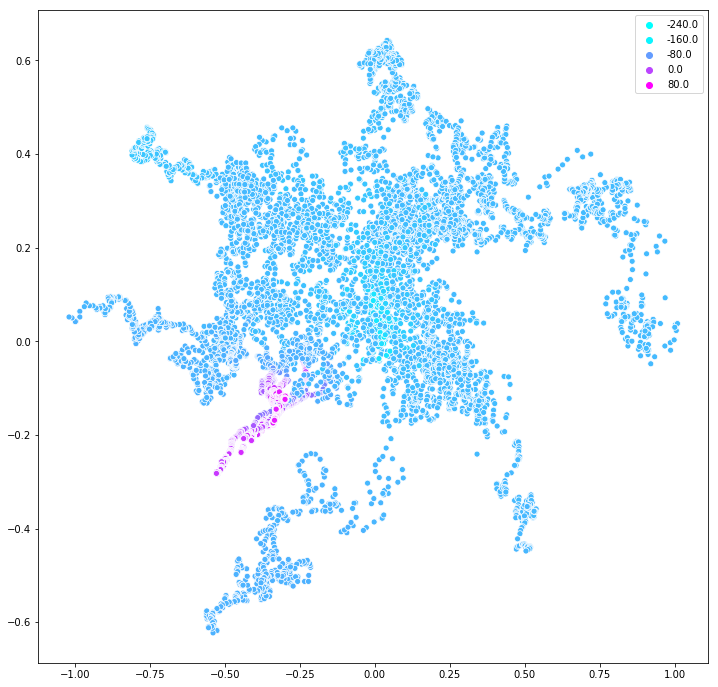

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=logs[:,0], y=logs[:,1], hue=logs[:,5], palette='cool')
plt.show();

HIGHLIGHTED RUN FINAL REWARD: -104.0


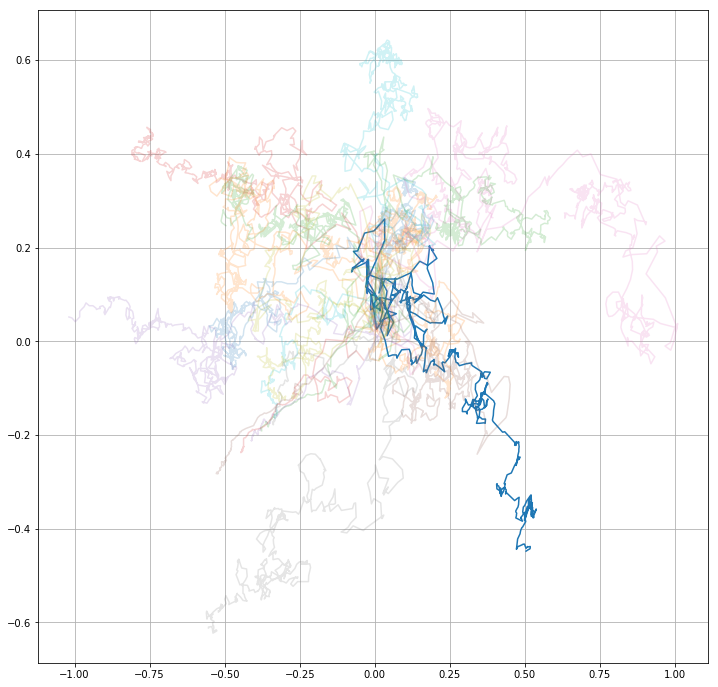

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
ci = 0
# GOOD RUNS:  6, 7, 8, 12, 14, 16, 18, 22
HIGHLIGHT = 0
print('HIGHLIGHTED RUN FINAL REWARD:', logs[sum(logs_length[:HIGHLIGHT+1])-1,5])
for i, log_len in enumerate(logs_length):
    ax.plot(logs[ci:ci+log_len,0], logs[ci:ci+log_len,1], alpha=1.0 if HIGHLIGHT == i else 0.2)
    ci += log_len
    ax.grid()
plt.show();

## Grid-search of parameters

In [7]:
np.mean(logs[np.where(logs[:, 5] > 0)], axis=0)

array([-3.75865868e-01, -1.80159339e-01, -1.39846523e-03, -1.31762325e-01,
       -6.42247586e-01,  2.64037809e+01])

In [8]:
base_args = {'n_episodes': 10, 'horizon': 500, 'njobs': 10, 'env': 'rllab.inverted-pendulum', 'policy': 'linear'}
logger.configure(dir='.', format_strs=[], file_name='x')
sampler = create_sampler(seed=42, **base_args)

In [ ]:
def evaluate_theta(theta):
    s = sampler.collect(theta)
    return np.sum(s['rew']) / base_args['n_episodes']
grid_logs = []
# First area
STEP = 0.1
MIN0, MAX0 = -1.0, (0.5 + STEP)
MIN1, MAX1 = -0.4, (0.4 + STEP)
pbar = tqdm_notebook(total=int(((MAX0 - MIN0) // STEP) * ((MAX1 - MIN1) // STEP)))
for p0 in np.arange(MIN0, MAX0, STEP):
    for p1 in np.arange(MIN1, MAX1, STEP):
        theta = np.array([p0, p1, -1.39846523e-03, -1.31762325e-01, -6.42247586e-01])
        r = evaluate_theta(theta)
        grid_logs.append(list(theta) + [r])
        pbar.update(1)
# Second area      
STEP = 0.02
MIN0, MAX0 = -0.7, (0.0 + STEP)
MIN1, MAX1 = -0.4, (0.0 + STEP)
pbar = tqdm_notebook(total=int(((MAX0 - MIN0) // STEP) * ((MAX1 - MIN1) // STEP)))
for p0 in np.arange(MIN0, MAX0, STEP):
    for p1 in np.arange(MIN1, MAX1, STEP):
        theta = np.array([p0, p1, -1.39846523e-03, -1.31762325e-01, -6.42247586e-01])
        r = evaluate_theta(theta)
        grid_logs.append(list(theta) + [r])
        pbar.update(1)
# Closing
grid_logs = np.array(grid_logs)
sampler.close()

In [ ]:
grid_all = np.concatenate([logs, grid_logs], axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=grid_all[:,0], y=grid_all[:,1], hue=grid_all[:,5], palette='rainbow', alpha=0.8)
plt.show();

In [ ]:
plt.hist(grid_all[:, 5], bins=100)
plt.show();

In [ ]:
logs[np.where(logs[:,5] == np.max(logs[:, 5]))]

In [18]:
theta_pois = [-2.750e-01, -1.209e-01,  5.964e-05, -1.013e-01, -1.174e+00]
theta_trpo = [-1.98413908e-01, -1.70024530e-01, 1.84314279e-03, -1.32606148e-01, -3.41643242e+00]
seg = sampler.collect(theta_trpo)

In [19]:
masks = np.reshape(seg['mask'], (10, 500))
rews = np.reshape(seg['rew'], (10, 500))

In [21]:
np.sum(rews) / 10

59.81329345703125